# ***Christopher Kennedy***
# ***Student ID: 109306056***
# ***AMS 691***
# ***Homework 3***



## Exercise 1: 3D Artery segmentation with MONAI

This exercise shows how to use MONAI for 3D artery segmentation.
  
Modality: CT  
Size: 100 3D volumes (60 Training + 20 Validation + 20 Testing)   


## Setup environment and check GPU status

*The first thing that needs to be done is installing Monai, since many of our packages that we will use later require it.*

In [ ]:
!pip install monai

*Next, we verify that the coorect version of Numpy is installed, for the same reason as above.*

In [ ]:
!pip install numpy==1.23.5

*And now we can proceed with the rest of the code.*

In [1]:
!python -c "import monai" || pip install -q --user "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
!nvidia-smi

2025-04-27 17:31:27.656540: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-27 17:31:27.673894: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745775087.693609    2499 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745775087.700053    2499 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-27 17:31:27.721842: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

*I kept my files in my drive, so this accesses them.*

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Setup imports

In [3]:
import os, glob
%matplotlib inline

from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    Spacingd,
    Invertd,
    ScaleIntensityRanged,
    RandCropByPosNegLabeld
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm

from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract

from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference

import torch
import numpy as np
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

#print_config()

## Set dataset path

**Task:** Download the segmentation dataset [here](https://drive.google.com/drive/folders/1vUdhDu9qLvZ9XEpyl7OV9n_iPmDLGC8i?usp=sharing).

In [4]:
train_images = []
train_labels = []

for item in sorted(glob.glob("/content/drive/MyDrive/segmentation_dataset/*")):
    sid = item.split('/')[-1]
    train_images.append(item+'/image/'+sid+'.nii.gz')
    train_labels.append(item+'/label/'+sid+'.nii.gz')

data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files, test_files = data_dicts[:60], data_dicts[60:80], data_dicts[80:]

print(len(train_files), len(val_files), len(test_files))

60 20 20


## Set deterministic training for reproducibility

In [5]:
set_determinism(seed=0)

## Setup transforms for training and validation

Here we use several transforms to augment the dataset:
1. `LoadImaged` loads the CT images and labels from NIfTI format files.
1. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
1. `Orientationd` unifies the data orientation based on the affine matrix.
1. `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.  
The image centers of negative samples must be in valid body area.
1. `EnsureTyped` converts the numpy array to PyTorch Tensor for further steps.

**Task 1.1:** Use MOMAI to rescale the intensity from [-1024,600] to [0,1], and clip outside value.

**Background:** Why clip the intensity range to [-1024,600]? Because in CT it covers from air to bone, which contain most lung anatomical structures we are interested in.

![alt text](https://firevoxel.org/docs/html/_images/view_hounsfield_scale.png "Title")

*Hint:* find a transform class in [monai.transforms](https://docs.monai.io/en/latest/transforms.html)

In [ ]:
## MY CODE HERE
scale_transform = Compose([ScaleIntensityRanged(keys=["image"],
                                                a_min=-1024,
                                                a_max=600,
                                                b_min=0,
                                                b_max=1,
                                                clip=True
                                                )])

**Task 1.2:** Use MOMAI to randomly crop patches sized of [96,96,96] for training, in order to save GPU memory. For each image, we crop 4 patch samples. And to balance the dataset, we ramdomly sample the patch center being a foreground or background voxel with 50% probability for each case.

*Hint:* find a transform class in [monai.transforms](https://docs.monai.io/en/latest/transforms.html)

In [ ]:
## MY CODE HERE
random_crop_transform = RandCropByPosNegLabeld(keys=["image", "label"],
                                               label_key="label",
                                               spatial_size=[96, 96, 96],
                                               pos=1,
                                               neg=1,
                                               num_samples=4,
                                               image_key="image",
                                               image_threshold=0
                                               )

In [ ]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        scale_transform,
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        random_crop_transform,
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        scale_transform,
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
    ]
)

/usr/local/lib/python3.11/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


## Check transforms in DataLoader

In [ ]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"sample image shape: {image.shape}, label shape: {label.shape}")

sample image shape: torch.Size([512, 512, 313]), label shape: torch.Size([512, 512, 313])


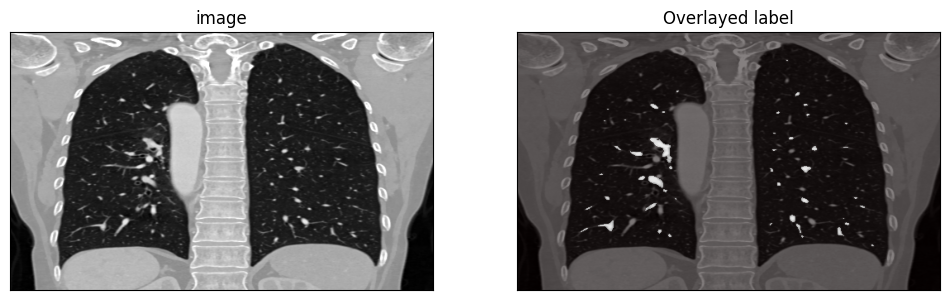

In [ ]:
# plot the slice [:, 180, :]
plt.figure("check", (12, 12))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, 180, :].transpose(0,1).flip(0), cmap="gray")
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.subplot(1, 2, 2)
plt.title("Overlayed label")

plt.imshow(image[:, 180, :].transpose(0,1).flip(0), alpha=1, cmap='gray')
plt.imshow(label[:, 180, :].transpose(0,1).flip(0), alpha=0.5, cmap='hot')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.show()

## Define CacheDataset and DataLoader for training and validation

**Task 1.3.1:** Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.   
And set `num_workers` to enable multi-threads during caching.  
**Hint:** Read more about CacheDataset [here](https://docs.monai.io/en/latest/data.html#cachedataset).

In [ ]:
## MY CODE HERE
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=0.25, num_workers=2)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=2)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=0.25, num_workers=2)

val_loader = DataLoader(val_ds, batch_size=1, num_workers=2)

Loading dataset: 100%|██████████| 5/5 [00:18<00:00,  3.74s/it]


*In the above cell, I had to lower a few parameters. I lowered the cache_rate to 0.25, the num_workers to 2, and the batch_size to 1 for all entries. I found these values to be ideal for the computer I was running this code on.*

## Create Model, Loss, Optimizer

**Task 1.3.2:** Initialze Dice Loss and Dice metric with MONAI. Because most samples will be in background, please exclude class 0 (background) when computing the Dice metric.

In [71]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda")

UNet_meatdata = {
    "spatial_dims": 3,
    "in_channels": 1,
    "out_channels": 2,
    "channels": (16, 32, 64, 128, 256),
    "strides": (2, 2, 2, 2),
    "num_res_units": 2,
    "norm": Norm.BATCH,
}

model = UNet(**UNet_meatdata).to(device)

## MY CODE HERE
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
loss_type = "DiceLoss"
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)

Optimizer_metadata = {}
for ind, param_group in enumerate(optimizer.param_groups):
    optim_meta_keys = list(param_group.keys())
    Optimizer_metadata[f"param_group_{ind}"] = {
        key: value for (key, value) in param_group.items() if "params" not in key
    }

## Train the model

**Task 1.4:** Convert the label format from label index to one-hot representation.


**Task 1.5.1:** Since for training, we adopt a patch-based approach. To do inference on the full image, we can use a sliding window approach. Specifically, we can run sliding window inference and aggregate the patch-wise predictions. Complete the inference code using MONAI, and set the window size to be [160,160,160].

In [ ]:
root_dir = './ckpt/'
os.makedirs(root_dir, exist_ok=True)

max_epochs = 50 # Lowered the epoch count from 90 to 50
print_interval = 15
val_interval = 1

best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
## MY CODE HERE
post_label = Compose([AsDiscrete(to_onehot=2)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if step % print_interval == 0:
            print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")


    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)


    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:

        model.eval()
        with torch.no_grad():
            for index, val_data in enumerate(val_loader):
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                ## MY CODE HERE

                val_outputs = sliding_window_inference(val_inputs,
                                                       roi_size=[160, 160, 160],
                                                       sw_batch_size=1,
                                                       predictor=model,
                                                       overlap=0.25)

                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # track val metric

            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))

                best_model_log_message = f"saved new best metric model at the {epoch+1}th epoch"

                print(best_model_log_message)

            message1 = f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
            message2 = f"\nbest mean dice: {best_metric:.4f} "
            message3 = f"at epoch: {best_metric_epoch}"

            print(message1, message2, message3)

----------
epoch 1/50
15/60, train_loss: 0.6484
30/60, train_loss: 0.6458
45/60, train_loss: 0.6085
60/60, train_loss: 0.6253
epoch 1 average loss: 0.6312
saved new best metric model at the 1th epoch
current epoch: 1 current mean dice: 0.0143 
best mean dice: 0.0143  at epoch: 1
----------
epoch 2/50
15/60, train_loss: 0.5972
30/60, train_loss: 0.5263
45/60, train_loss: 0.5768
60/60, train_loss: 0.5760
epoch 2 average loss: 0.5903
saved new best metric model at the 2th epoch
current epoch: 2 current mean dice: 0.0201 
best mean dice: 0.0201  at epoch: 2
----------
epoch 3/50
15/60, train_loss: 0.5823
30/60, train_loss: 0.5589
45/60, train_loss: 0.5354
60/60, train_loss: 0.5538
epoch 3 average loss: 0.5658
saved new best metric model at the 3th epoch
current epoch: 3 current mean dice: 0.0468 
best mean dice: 0.0468  at epoch: 3
----------
epoch 4/50
15/60, train_loss: 0.5795
30/60, train_loss: 0.4679
45/60, train_loss: 0.5634
60/60, train_loss: 0.5640
epoch 4 average loss: 0.5428
saved

In [ ]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.7015 at epoch: 46


If your best dice metric is around 0.75, then you are on good track.

*For the same reason I had to lower some of the variables in a previous code cell, I also had to lower the epoch count from 90 to 50. This is the most likely reason that my dice metric didn't reach 0.75. However, it got fairly close.*

In [ ]:
# Save the model in case of further use
torch.save(model.state_dict(), 'my_model.pth')

In [ ]:
# Reload the model in case of further use
model.load_state_dict(torch.load('my_model.pth'))

*The above two code cells are for the sole purpose of saving and reloading the model if necessary, so that once I got a model I was satisfied with, I would not have to retrain.*

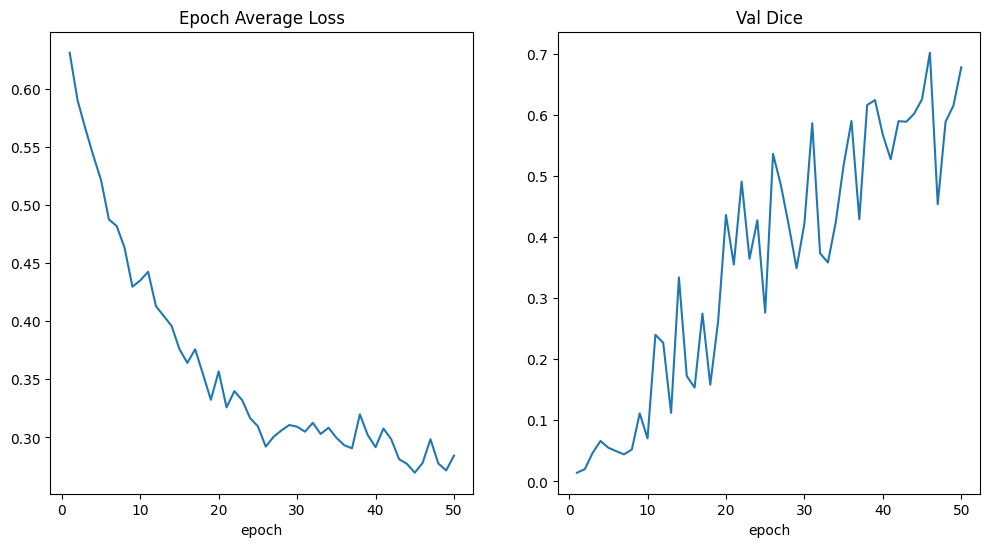

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Visualize the prediction

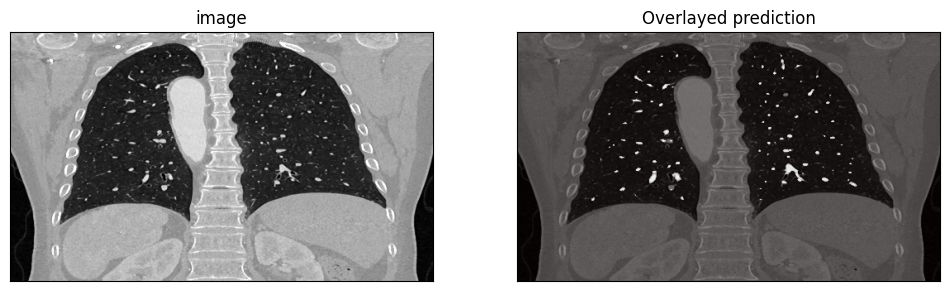

In [ ]:
# plot the slice [:, 180, :]
image = val_inputs[0,0].detach().cpu()
label = val_outputs[0][1].detach().cpu()

plt.figure("check", (12, 12))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, 180, :].transpose(0,1).flip(0), cmap="gray")
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.subplot(1, 2, 2)
plt.title("Overlayed prediction")
plt.imshow(image[:, 180, :].transpose(0,1).flip(0), alpha=1, cmap='gray')
plt.imshow(label[:, 180, :].transpose(0,1).flip(0), alpha=0.5, cmap='hot')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.show()

## Predict on the test set

**Task 1.5.2:** Complete the inference code below

In [ ]:
test_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        ScaleIntensityRanged(keys=["image"],
                                                a_min=-1024,
                                                a_max=600,
                                                b_min=0,
                                                b_max=1,
                                                clip=True
                                                ),
        CropForegroundd(keys=["image"], source_key="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
    ]
)
## MYCODE HERE
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1, num_workers=2)

/usr/local/lib/python3.11/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [ ]:
root_dir = './ckpt/'
save_dir = './results/'
os.makedirs(save_dir, exist_ok=True)

model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
# MY CODE HERE
post_label = Compose([AsDiscrete(to_onehot=2)])

model.eval()
with torch.no_grad():
    for index, val_data in enumerate(test_loader):
        val_inputs = val_data["image"].to(device)
        ## MY CODE HERE
        val_outputs = sliding_window_inference(val_inputs, roi_size=[160, 160, 160], sw_batch_size=1, predictor=model, overlap=0.25)

        val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]

        val_outputs = val_outputs[0][1].detach().cpu().numpy().astype(bool)
        if index == 0:
            print(val_outputs.shape)
        np.savez_compressed(os.path.join(save_dir, str(index)+'.npz'), val_outputs)

**Task 1.6:** Please save your best predictions on test set in a tar.gz file and submit it through GradeScope.

In [ ]:
!tar -cf results.tar.gz results

## Using Smoothing Recursive Gaussian filtering as an extra input channel

One idea to further improve our segmentation is to leverge [Objectness Measure filter](https://itk.org/Doxygen50/html/classitk_1_1ObjectnessMeasureImageFilter.html) with different scales of Gaussian smoothing filter.
Because filtered image may make vessels more visible.
In the code block below, we concatenate real image and filtered image together as input for U-Net.

**Reading material:** You can read more about vesselness [here](https://link.springer.com/chapter/10.1007/BFb0056195).

In [6]:
!pip install SimpleITK
import SimpleITK as sitk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 MB 47.2 MB/s eta 0:00:00


**Task 1.6:** Play with hyperparameters below until you see clear trace of vessels

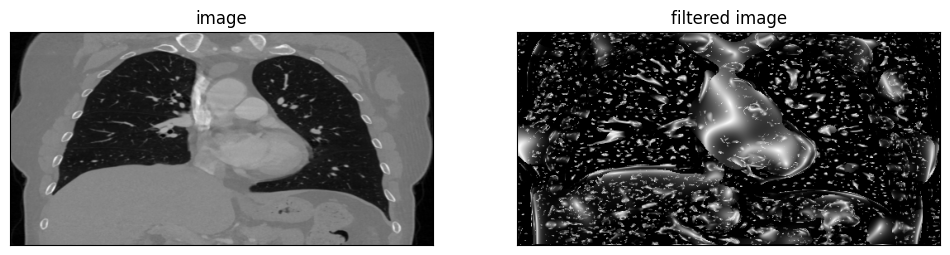

In [62]:
input_image = sitk.ReadImage(train_files[0]['image'], sitk.sitkFloat32)

# Set the parameters for the objectness measure

sigmas = [1.0, 2.0, 4.0, 8.0, 16.0]
images = [
    sitk.ObjectnessMeasure(
        sitk.SmoothingRecursiveGaussian(input_image, s),
        alpha=1.0,
        beta=10.0,
        gamma=0.1,
        scaleObjectnessMeasure=False,
        brightObject=True,
    )
    for s in sigmas
]
result = sitk.MaximumProjection(sitk.JoinSeries(images), projectionDimension=images[0].GetDimension())

image = sitk.GetArrayFromImage(input_image)
label = sitk.GetArrayFromImage(result)[0]

plt.figure("check", (12, 12))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(np.flip(image[:, 250, :], 0), cmap="gray")
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.subplot(1, 2, 2)
plt.title("filtered image")
plt.imshow(np.flip(label[:, 250, :], 0), cmap="gray")
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.show()

When you see the filtering is working, run the filtering on the full dataset.

*After trying many different values for paramters, this was the closest I could get to what appear to be vessels in the filtered image.*

In [64]:
filter_img_dir = './filter_img/'
os.makedirs(filter_img_dir, exist_ok=True)

for idx, item in enumerate(sorted(glob.glob("/content/drive/MyDrive/segmentation_dataset/*"))[:80]):
    sid = item.split('/')[-1]
    image_path = item+'/image/'+sid+'.nii.gz'

    input_image = sitk.ReadImage(image_path, sitk.sitkFloat32)

    # Set the parameters for the objectness measure according to specific input,
    images = [
        sitk.ObjectnessMeasure(
            sitk.SmoothingRecursiveGaussian(input_image, s),
            alpha=1.0,
            beta=10,
            gamma=0.1,
            scaleObjectnessMeasure=False,
            objectDimension=1,
            brightObject=True,
        )
        for s in sigmas
    ]
    result = sitk.MaximumProjection(sitk.JoinSeries(images), projectionDimension=images[0].GetDimension())
    sitk.WriteImage(result, os.path.join(filter_img_dir, sid+'.nii.gz'))


In [65]:
train_images = []
train_labels = []
train_filtered_img = []
filter_img_dir = './filter_img/'

for item in sorted(glob.glob("/content/drive/MyDrive/segmentation_dataset/*")):
    sid = item.split('/')[-1]
    train_images.append(item+'/image/'+sid+'.nii.gz')
    train_labels.append(item+'/label/'+sid+'.nii.gz')
    train_filtered_img.append(filter_img_dir+sid+'.nii.gz')

data_dicts = [{"image": image_name, "label": label_name, 'filtered_img': filtered_img_name} \
              for image_name, label_name, filtered_img_name in zip(train_images, train_labels, train_filtered_img)]
train_files, val_files, test_files = data_dicts[:60], data_dicts[60:80], data_dicts[80:]

**Task 1.7:** Complete the random crop transform similar to Task 1.2. But in this time, you will need to corp filtered image as well.

In [66]:
## MY CODE HERE
random_crop_transform = RandCropByPosNegLabeld(
    keys=["image", "filtered_img", "label"],
    label_key="label",
    spatial_size=[96, 96, 96],
    pos=1,
    neg=1,
    num_samples=4,
    image_key="image",
    image_threshold=0
)

In [67]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "filtered_img", "label"]),
        EnsureChannelFirstd(keys=["image", "filtered_img", "label"]),
        ScaleIntensityRanged(keys=["image"],
                                                a_min=-1024,
                                                a_max=600,
                                                b_min=0,
                                                b_max=1,
                                                clip=True
                                                ),
        CropForegroundd(keys=["image", "filtered_img", "label"], source_key="image"),
        Orientationd(keys=["image", "filtered_img", "label"], axcodes="RAS"),
        random_crop_transform,
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "filtered_img", "label"]),
        EnsureChannelFirstd(keys=["image", "filtered_img", "label"]),
        ScaleIntensityRanged(keys=["image"],
                                                a_min=-1024,
                                                a_max=600,
                                                b_min=0,
                                                b_max=1,
                                                clip=True
                                                ),
        CropForegroundd(keys=["image", "filtered_img", "label"], source_key="image"),
        Orientationd(keys=["image", "filtered_img", "label"], axcodes="RAS"),
    ]
)

/usr/local/lib/python3.11/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [68]:
# MY CODE HERE
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=0.25, num_workers=2)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=2)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=0.25, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=2)

Loading dataset: 100%|██████████| 5/5 [00:30<00:00,  6.11s/it]


In [72]:
# MY CODE HERE
UNet_meatdata = {
    "spatial_dims": 3,
    "in_channels": 2,
    "out_channels": 2,
    "channels": (16, 32, 64, 128, 256),
    "strides": (2, 2, 2, 2),
    "num_res_units": 2,
    "norm": Norm.BATCH,
}

device = torch.device("cuda")
model = UNet(**UNet_meatdata).to(device)

optimizer = torch.optim.Adam(model.parameters(), 1e-4)

Optimizer_metadata = {}
for ind, param_group in enumerate(optimizer.param_groups):
    optim_meta_keys = list(param_group.keys())
    Optimizer_metadata[f"param_group_{ind}"] = {
        key: value for (key, value) in param_group.items() if "params" not in key
    }

In [75]:
root_dir = './ckpt_filtered/'
os.makedirs(root_dir, exist_ok=True)

max_epochs = 50
print_interval = 15
val_interval = 1

best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])

post_label = Compose([AsDiscrete(to_onehot=2)])
# Pasted this line from the above model training section, in case I could not
# run both sets of training in one session

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, inputs_filered, labels = (
            batch_data["image"].to(device),
            batch_data["filtered_img"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(torch.cat([inputs, inputs_filered], dim=1))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if step % print_interval == 0:
            print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")


    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)


    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:

        model.eval()
        with torch.no_grad():
            for index, val_data in enumerate(val_loader):
                val_inputs, val_inputs_filtered, val_labels = (
                    val_data["image"].to(device),
                    val_data["filtered_img"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = sliding_window_inference(torch.cat([val_inputs, val_inputs_filtered], dim=1), roi_size=[160, 160, 160], sw_batch_size=1, predictor=model, overlap=0.25)

                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # track val metric

            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))

                best_model_log_message = f"saved new best metric model at the {epoch+1}th epoch"

                print(best_model_log_message)

            message1 = f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
            message2 = f"\nbest mean dice: {best_metric:.4f} "
            message3 = f"at epoch: {best_metric_epoch}"

            print(message1, message2, message3)

----------
epoch 1/50
15/60, train_loss: 0.4535
30/60, train_loss: 0.5180
45/60, train_loss: 0.3309
60/60, train_loss: 0.3111
epoch 1 average loss: 0.3955
saved new best metric model at the 1th epoch
current epoch: 1 current mean dice: 0.1695 
best mean dice: 0.1695  at epoch: 1
----------
epoch 2/50
15/60, train_loss: 0.3181
30/60, train_loss: 0.3346
45/60, train_loss: 0.4437
60/60, train_loss: 0.1976
epoch 2 average loss: 0.3834
saved new best metric model at the 2th epoch
current epoch: 2 current mean dice: 0.1942 
best mean dice: 0.1942  at epoch: 2
----------
epoch 3/50
15/60, train_loss: 0.2316
30/60, train_loss: 0.4132
45/60, train_loss: 0.3784
60/60, train_loss: 0.4870
epoch 3 average loss: 0.3553
saved new best metric model at the 3th epoch
current epoch: 3 current mean dice: 0.2854 
best mean dice: 0.2854  at epoch: 3
----------
epoch 4/50
15/60, train_loss: 0.2707
30/60, train_loss: 0.3262
45/60, train_loss: 0.4376
60/60, train_loss: 0.3439
epoch 4 average loss: 0.3573
curre

In [76]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.7062 at epoch: 41


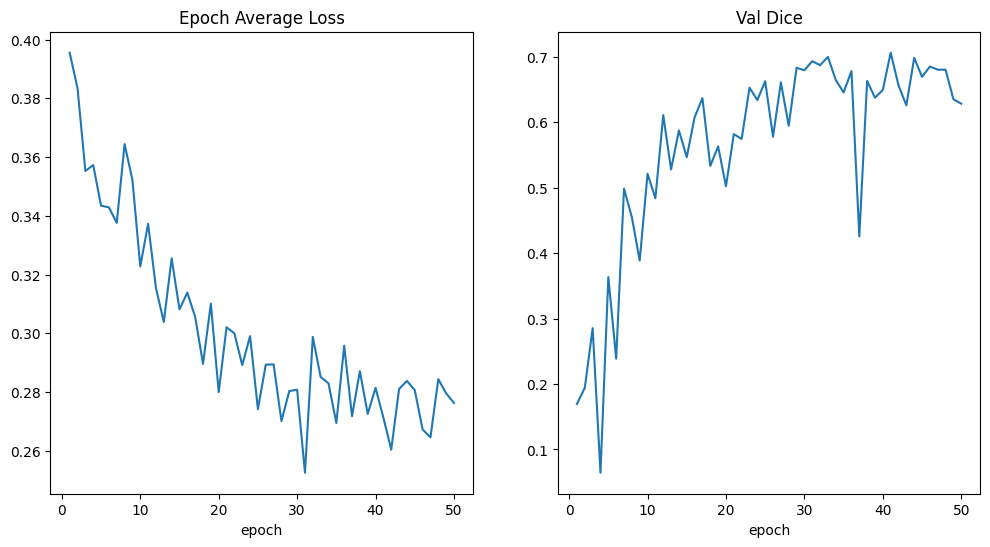

In [77]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

Because the filtering process is sensitive to the hyperparameter chosen. If your initial validation Dice is equal or less then the baseline (0.7536), that's still fine, there won't be penality.

Please tune the parameter in the Objectness Measure filter to achieve better performance on validation set. If your performance outperforms base methods, we will give you bonus.

## ***END OF EXERCISE 1***

# *Since the following section was determined to not count towards the homework grade, this section is incomplete. However, there are code cells that are filled. The code itself however, is not fully executed, since I could not download the full dataset.*

## Exercise 2: Object Detection on Digital Mammography

# 🚩 Task 1 - Download and Learn the Dataset

In this problem, you are required to perform Object Detection on a subset of the [VinDr-Mammo benchmark](https://www.nature.com/articles/s41597-023-02100-7), which is a Vietnamese dataset consisting of 5,000 four-view exams of **digital mammography** with *breast-level assessment and extensive lesion-level annotations*. Each of these exams was independently double read, with discordance (if any) being resolved by arbitration by a third radiologist. This benchmark is designed as a new imaging resource to promote advances in developing computer-aided detection and diagnosis (CADe/x) tools for breast cancer screening.

Please check their [Introduction Webpage](https://vindr.ai/datasets/mammo), [Annotation Description](https://www.kaggle.com/datasets/hadighahroudi/vindr-mammo-dataset/data), and [Published Paper](https://www.nature.com/articles/s41597-023-02100-7) for more details.

<img src="https://drive.google.com/uc?id=1tGaT5aAYmbzEcowVuu8LoLBnFygcXjYW" alt="Image">

In [ ]:
# Download utility code and check GPU status
!wget -q https://raw.githubusercontent.com/charlesyou999648/MedIA/main/homework3/anchor_utils.py
!wget -q https://raw.githubusercontent.com/charlesyou999648/MedIA/main/homework3/data_loader.py
!wget -q https://raw.githubusercontent.com/charlesyou999648/MedIA/main/homework3/model_blocks.py
!wget -q https://raw.githubusercontent.com/charlesyou999648/MedIA/main/homework3/model_utils.py
!wget -q https://raw.githubusercontent.com/charlesyou999648/MedIA/main/homework3/utils.py
!nvidia-smi

## Problem 1.1 - Download the Dataset and Review Annotation File (5 Points)

🔥 The **dataset** can be downloaded from [here](https://www.physionet.org/content/vindr-mammo/1.0.0/).


Now, unzip the dataset using the following command line: (you may need to adjust the folder path)

In [ ]:
!unzip -q /content/detection_dataset.zip

Please explore the dataset using the provided codes:

In [ ]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('annotation.csv', low_memory=False)

# Print the shape of the file
print("Shape of the file:", df.shape, '\n\n')

# Print the number of unique "finding_categories"
num_unique_categories = df['finding_categories'].nunique()
print("Number of unique finding_categories:", num_unique_categories, '\n\n')

# Show all unique finding_categories
print("Unique finding_categories:")
print(df['finding_categories'].unique(), '\n\n')

# Show the first two lines and all information
print("First two lines with all information:")
print(df.head(2).to_string(index=False), '\n\n')


Considering the computational load, you are encouraged to sample a subset data from the whole benchmark. In specific, the abnormalities of **Mass** are utilized to construct the training set and testing set.


**Your Task**: Please filter all the lines where finding_categories include "Mass" and save the filtered rows to mass_annotation.csv

In [ ]:
import csv

# Define the input and output filenames
input_filename = 'annotation.csv'
output_filename = 'mass_annotation.csv'

# Open the input CSV file
with open(input_filename, newline='') as csvfile:
    # Assuming comma-separated values, adjust delimiter if necessary
    reader = csv.DictReader(csvfile)

    # Initialize a list to store filtered rows
    filtered_rows = []

    #### STUDENT'S CODE START HERE ####
    for row in reader:
      if "Mass" in row['finding_categories']:
        filtered_rows.append(row)

with open(output_filename, 'w', newline='') as csvfile:
  writer = csv.DicWriter(csvfile, fieldnames=reader.fieldnames)
  writer.writeheader()
  writer.writerows(filtered_rows)

    #### STUDENT'S CODE END HERE ####

 Please review the information of the filtered file "mass_annotation". If the dataframe from "mass_annotation" has a shape of (1226, 38), then your filtering process is good.

**Your Task**:
Please complete the code below to show the number of training and testing samples.

In [ ]:
import csv
import pandas as pd

# Read the CSV file
df = pd.read_csv('mass_annotation.csv', low_memory=False)

# Print the shape of the file
print("Shape of the file:", df.shape, '\n\n')

# Print the number of unique "finding_categories"
num_unique_categories = df['finding_categories'].nunique()
print("Number of unique finding_categories:", num_unique_categories, '\n\n')

#### STUDENT'S CODE START HERE ####
# Show all unique finding_categories
print("Unique finding_categories:")
print(df['finding_categories'].unique(), '\n\n')

# Show the first two lines and all information
print("First two lines with all information:")
print(df.head(2).to_string(index=False), '\n\n')

# Show the number of training and testing data
# Filter the DataFrame to count the number of lines where the value in the "split" column is "training"
print("Number of training data:")
print(len(df[df['split'] == 'training']))

# Filter the DataFrame to count the number of lines where the value in the "split" column is "testing"
print("Number of testing data:")
print(len(df[df['split'] == 'testing']))

#### STUDENT'S CODE END HERE ####

## Problem 1.2 - Implement the Intersection over Union (IoU) and the Cross-Entropy Loss (10 Points)

### Problem 1.2.1
The dimensionality of $a$ and $b$ are [num_boxes, 4], where 4 is [x_min, y_min, x_max, y_max]. Please implement the Intersection over Union (IoU) for object detection step by step:

<1> Calculate the area of $b$ box.

<2> Calculate the intersection width (iw) and intersection height (ih)

<3> Calculate the union area (ua) between $a$ and $b$

<4> Calculate the intersection area

<5> Calculate Intersection over Union (IoU)

### Problem 1.2.2
Cross entropy (CE) loss for binary classification:

\begin{equation}
\mathrm{CE}(p, y)= \begin{cases}-\log (p) & \text { if } y=1, \\ -\log (1-p) & \text { otherwise, }\end{cases}
\end{equation}

where $y \in\{ \pm 1\}$ specifies the ground-truth class and $p \in[0,1]$ is the model’s estimated probability for the class
with label $y = 1$.

In [ ]:
import torch


def calc_iou(a, b):
    # Calculate the area of bounding boxes 'b'
    area = (b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1])

    # Calculate the intersection width (iw) and intersection height (ih)
    iw = torch.min(torch.unsqueeze(a[:, 2], dim=1), b[:, 2]) - torch.max(torch.unsqueeze(a[:, 0], 1), b[:, 0])
    ih = torch.min(torch.unsqueeze(a[:, 3], dim=1), b[:, 3]) - torch.max(torch.unsqueeze(a[:, 1], 1), b[:, 1])

    # Clamp the values of iw and ih to 0 to ensure non-negative values
    iw = torch.clamp(iw, min=0)
    ih = torch.clamp(ih, min=0)

    # Calculate the union area (ua) between 'a' and 'b'
    ua = torch.unsqueeze((a[:, 2] - a[:, 0]) * (a[:, 3] - a[:, 1]), dim=1) + area - iw * ih

    # Clamp the value of ua to avoid division by zero
    ua = torch.clamp(ua, min=1e-8)

    # Calculate the intersection area
    intersection = iw * ih

    # Calculate Intersection over Union (IoU)
    IoU = intersection / ua

    return IoU


In [ ]:
import torch.nn as nn


class CrossEntropyLoss(nn.Module):
    """Cross Entropy Loss"""
    def __init__(self):
        super(CrossEntropyLoss, self).__init__()

    def forward(self, classifications, regressions, anchors, annotations):
        batch_size = classifications.shape[0]
        classification_losses = []
        regression_losses = []

        anchor = anchors[0, :, :]
        anchor_widths = anchor[:, 2] - anchor[:, 0]
        anchor_heights = anchor[:, 3] - anchor[:, 1]
        anchor_ctr_x = anchor[:, 0] + 0.5 * anchor_widths
        anchor_ctr_y = anchor[:, 1] + 0.5 * anchor_heights
        device = classifications.device

        for j in range(batch_size):
            classification = classifications[j, :, :]
            regression = regressions[j, :, :]

            bbox_annotation = annotations[j, :, :]
            bbox_annotation = bbox_annotation[bbox_annotation[:, 4] != -1]

            if bbox_annotation.shape[0] == 0:
                regression_losses.append(torch.tensor(0).float().to(device))
                classification_losses.append(torch.tensor(0).float().to(device))

                continue

            classification = torch.clamp(classification, 1e-4, 1.0 - 1e-4)

            # num_anchors x num_annotations
            IoU = calc_iou(anchors[0, :, :], bbox_annotation[:, :4])
            IoU_max, IoU_argmax = torch.max(IoU, dim=1)  # num_anchors x 1

            # compute the loss for classification
            targets = torch.ones(classification.shape) * -1
            targets = targets.to(device)
            targets[torch.lt(IoU_max, 0.4), :] = 0

            positive_indices = torch.ge(IoU_max, 0.5)
            num_positive_anchors = positive_indices.sum()
            assigned_annotations = bbox_annotation[IoU_argmax, :]

            targets[positive_indices, :] = 0
            targets[positive_indices, assigned_annotations[positive_indices, 4].long()] = 1

            #### STUDENT'S CODE START HERE ####
            # Cross Entropy Loss, please don't directly use F.cross_entropy
            cls_loss = - (targets * torch.log(classification) + (1.0 - targets) * torch.log(1.0 - classification))

            #### STUDENT'S CODE END HERE ####

            cls_loss = torch.where(torch.ne(targets, -1.0), cls_loss, torch.zeros(cls_loss.shape).to(device),)
            classification_losses.append(cls_loss.sum() / torch.clamp(num_positive_anchors.float(), min=1.0))

            # compute the loss for regression
            if positive_indices.sum() > 0:
                assigned_annotations = assigned_annotations[positive_indices, :]

                anchor_widths_pi = anchor_widths[positive_indices]
                anchor_heights_pi = anchor_heights[positive_indices]
                anchor_ctr_x_pi = anchor_ctr_x[positive_indices]
                anchor_ctr_y_pi = anchor_ctr_y[positive_indices]

                gt_widths = assigned_annotations[:, 2] - assigned_annotations[:, 0]
                gt_heights = assigned_annotations[:, 3] - assigned_annotations[:, 1]
                gt_ctr_x = assigned_annotations[:, 0] + 0.5 * gt_widths
                gt_ctr_y = assigned_annotations[:, 1] + 0.5 * gt_heights

                # clip widths to 1
                gt_widths = torch.clamp(gt_widths, min=1)
                gt_heights = torch.clamp(gt_heights, min=1)

                targets_dx = (gt_ctr_x - anchor_ctr_x_pi) / anchor_widths_pi
                targets_dy = (gt_ctr_y - anchor_ctr_y_pi) / anchor_heights_pi
                targets_dw = torch.log(gt_widths / anchor_widths_pi)
                targets_dh = torch.log(gt_heights / anchor_heights_pi)

                targets = torch.stack((targets_dx, targets_dy, targets_dw, targets_dh))
                targets = targets.t()
                targets = targets / torch.Tensor([[0.1, 0.1, 0.2, 0.2]]).to(device)

                regression_diff = torch.abs(targets - regression[positive_indices, :])
                regression_loss = torch.where(
                    torch.le(regression_diff, 1.0 / 9.0),
                    0.5 * 9.0 * torch.pow(regression_diff, 2),
                    regression_diff - 0.5 / 9.0,
                )
                regression_losses.append(regression_loss.mean())
            else:
                regression_losses.append(torch.tensor(0).float().to(device))

        return torch.stack(classification_losses).mean(dim=0, keepdim=True), torch.stack(regression_losses).mean(dim=0, keepdim=True)


## Problem 1.3 - Implement the Focal Loss (10 Points)

For this task, you are required to implement the Focal Loss, as described in [this paper](https://arxiv.org/pdf/1708.02002.pdf).

\begin{equation}
\mathrm{FL}\left(p_{\mathrm{t}}\right)=-\left(1-p_{\mathrm{t}}\right)^\gamma \log \left(p_{\mathrm{t}}\right),
\end{equation}

where

\begin{equation}
p_{\mathrm{t}}= \begin{cases}p & \text { if } y=1, \\ 1-p & \text { otherwise, }\end{cases}
\end{equation}

and $\gamma \geq 0$ is a tunable focusing parameter.

In [ ]:
import torch
import torch.nn as nn


class FocalLoss(nn.Module):
    """focal loss"""
    def __init__(self, focal_alpha, focal_gamma):
        super(FocalLoss, self).__init__()

        self.alpha = focal_alpha
        self.gamma = focal_gamma

    def forward(self, classifications, regressions, anchors, annotations):
        batch_size = classifications.shape[0]
        classification_losses = []
        regression_losses = []

        anchor = anchors[0, :, :]
        anchor_widths = anchor[:, 2] - anchor[:, 0]
        anchor_heights = anchor[:, 3] - anchor[:, 1]
        anchor_ctr_x = anchor[:, 0] + 0.5 * anchor_widths
        anchor_ctr_y = anchor[:, 1] + 0.5 * anchor_heights
        device = classifications.device

        for j in range(batch_size):
            classification = classifications[j, :, :]
            regression = regressions[j, :, :]

            bbox_annotation = annotations[j, :, :]
            bbox_annotation = bbox_annotation[bbox_annotation[:, 4] != -1]

            if bbox_annotation.shape[0] == 0:
                regression_losses.append(torch.tensor(0).float().to(device))
                classification_losses.append(torch.tensor(0).float().to(device))

                continue

            classification = torch.clamp(classification, 1e-4, 1.0 - 1e-4)

            # num_anchors x num_annotations
            IoU = calc_iou(anchors[0, :, :], bbox_annotation[:, :4])
            IoU_max, IoU_argmax = torch.max(IoU, dim=1)  # num_anchors x 1

            # compute the loss for classification
            targets = torch.ones(classification.shape) * -1
            targets = targets.to(device)
            targets[torch.lt(IoU_max, 0.4), :] = 0

            positive_indices = torch.ge(IoU_max, 0.5)
            num_positive_anchors = positive_indices.sum()
            assigned_annotations = bbox_annotation[IoU_argmax, :]

            targets[positive_indices, :] = 0
            targets[positive_indices, assigned_annotations[positive_indices, 4].long()] = 1

            alpha_factor = torch.ones(targets.shape).to(device) * self.alpha
            alpha_factor = torch.where(torch.eq(targets, 1.0), alpha_factor, 1.0 - alpha_factor)
            focal_weight = torch.where(torch.eq(targets, 1.0), 1.0 - classification, classification)
            focal_weight = alpha_factor * torch.pow(focal_weight, self.gamma)

            #### STUDENT'S CODE HERE ####
            cls_loss = focal_weight * torch.pow(classification - targets, 2) * torch.log(classification)

            cls_loss = torch.where(torch.ne(targets, -1.0), cls_loss, torch.zeros(cls_loss.shape).to(device),)
            classification_losses.append(cls_loss.sum() / torch.clamp(num_positive_anchors.float(), min=1.0))

            # compute the loss for regression
            if positive_indices.sum() > 0:
                assigned_annotations = assigned_annotations[positive_indices, :]

                anchor_widths_pi = anchor_widths[positive_indices]
                anchor_heights_pi = anchor_heights[positive_indices]
                anchor_ctr_x_pi = anchor_ctr_x[positive_indices]
                anchor_ctr_y_pi = anchor_ctr_y[positive_indices]

                gt_widths = assigned_annotations[:, 2] - assigned_annotations[:, 0]
                gt_heights = assigned_annotations[:, 3] - assigned_annotations[:, 1]
                gt_ctr_x = assigned_annotations[:, 0] + 0.5 * gt_widths
                gt_ctr_y = assigned_annotations[:, 1] + 0.5 * gt_heights

                # clip widths to 1
                gt_widths = torch.clamp(gt_widths, min=1)
                gt_heights = torch.clamp(gt_heights, min=1)

                targets_dx = (gt_ctr_x - anchor_ctr_x_pi) / anchor_widths_pi
                targets_dy = (gt_ctr_y - anchor_ctr_y_pi) / anchor_heights_pi
                targets_dw = torch.log(gt_widths / anchor_widths_pi)
                targets_dh = torch.log(gt_heights / anchor_heights_pi)

                targets = torch.stack((targets_dx, targets_dy, targets_dw, targets_dh))
                targets = targets.t()
                targets = targets / torch.Tensor([[0.1, 0.1, 0.2, 0.2]]).to(device)

                regression_diff = torch.abs(targets - regression[positive_indices, :])
                regression_loss = torch.where(
                    torch.le(regression_diff, 1.0 / 9.0),
                    0.5 * 9.0 * torch.pow(regression_diff, 2),
                    regression_diff - 0.5 / 9.0,
                )
                regression_losses.append(regression_loss.mean())
            else:
                regression_losses.append(torch.tensor(0).float().to(device))

        return torch.stack(classification_losses).mean(dim=0, keepdim=True), torch.stack(regression_losses).mean(dim=0, keepdim=True)


### 🤔 **Question**: Why employing the Focal Loss is more effective than the Cross Entropy Loss? Please answer the question from the perspective of mathematical definitions of two losses. (5 Points)

### **YOUR ANSWER**:

# 🚩 Task 2 - Training a Object Detection Model

To implement object detection, we will implement ResNet as the [RetinaNet](https://arxiv.org/pdf/1708.02002.pdf) backbone.

You are encouraged to read this [MONAI Tutorial](https://github.com/Project-MONAI/tutorials/tree/main/detection#detection-example) to learn more about the framework.

## Problem 2.1 - Building a ResNet Backbone (with Cross Entropy Loss) (15 Points)

In [ ]:
import math

import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
from torchvision.ops import nms

from anchor_utils import Anchors
from model_blocks import (
    BasicBlock,
    Bottleneck,
    ClassificationModel,
    RegressionModel,
    PyramidFeatures
)
from utils import BBoxTransform, ClipBoxes


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
}


def resnet18(num_classes, pretrained=True, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(num_classes, BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18'], model_dir='.'), strict=False)
    return model

### Problem (1):
**Implement the ResNet class:**

1. Set the initial value of self.inplanes to 64.
2. Create a convolutional layer (self.conv1) with parameters as follows:
    - Input channels: 3
    - Output channels: 64
    - Kernel size: 7 x 7
    - Stride: 2
    - Padding: 3
    - Bias: False
3. Add a batch normalization layer (self.bn1) with 64 channels.
4. Apply ReLU activation function (self.relu).
5. Add a max-pooling layer (self.maxpool) with kernel size 3 x 3, stride 2, and padding 1.
6. Create four layers (self.layer1, self.layer2, self.layer3, self.layer4) using the _make_layer method with the given parameters: block, 64, layers[0]; block, 128, layers[1], stride=2; block, 256, layers[2], stride=2; block, 512, layers[3], stride=2.


---

### Problem (2):

Please use the Cross Entropy Loss here.

---

### Problem (3):

**Implement the forward pass of the ResNet class:**

1. Complete the forward pass by passing the input batch through the convolutional layer, batch normalization layer, ReLU activation, and max-pooling layer.

2. Pass the resulting tensor through the layers of the ResNet block (self.layer1, self.layer2, self.layer3, self.layer4).

3. Finally, compute features using the FPN module with the provided intermediate features.

In [ ]:
# RetinaNet with ResNet backbone
class ResNet(nn.Module):
    def __init__(self, num_classes, block, layers):
        super(ResNet, self).__init__()

        #### STUDENT'S CODE START HERE ####

        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLu(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        #### STUDENT'S CODE END HERE ####

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        if block == BasicBlock:
            fpn_sizes = [
                self.layer2[layers[1] - 1].conv2.out_channels,
                self.layer3[layers[2] - 1].conv2.out_channels,
                self.layer4[layers[3] - 1].conv2.out_channels
            ]
        elif block == Bottleneck:
            fpn_sizes = [
                self.layer2[layers[1] - 1].conv3.out_channels,
                self.layer3[layers[2] - 1].conv3.out_channels,
                self.layer4[layers[3] - 1].conv3.out_channels
            ]
        else:
            raise ValueError(f"Block type {block} not understood")

        self.fpn = PyramidFeatures(fpn_sizes[0], fpn_sizes[1], fpn_sizes[2])
        self.regressionModel = RegressionModel(256)
        self.classificationModel = ClassificationModel(256, num_classes=num_classes)

        self.anchors = Anchors()
        self.regressBoxes = BBoxTransform()
        self.clipBoxes = ClipBoxes()

        #### STUDENT'S CODE START HERE ####
        self.crossentropyloss = CrossEntropyLoss()

        #### STUDENT'S CODE END HERE ####

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

        prior = 0.01

        self.classificationModel.output.weight.data.fill_(0)
        self.classificationModel.output.bias.data.fill_(-math.log((1.0 - prior) / prior))
        self.regressionModel.output.weight.data.fill_(0)
        self.regressionModel.output.bias.data.fill_(0)

        self.freeze_bn()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = [block(self.inplanes, planes, stride, downsample)]
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def freeze_bn(self):
        '''Freeze BatchNorm layers.'''
        for layer in self.modules():
            if isinstance(layer, nn.BatchNorm2d):
                layer.eval()

    def forward(self, inputs):
        if self.training:
            img_batch, annotations = inputs
        else:
            img_batch = inputs

        #### STUDENT'S CODE START HERE ####
        features = self.conv1(img_batch)
        features = self.bn1(features)
        features = self.relu(features)
        features = self.maxpool(features)

        features1 = self.layer1(features)
        features2 = self.layer2(features1)
        features3 = self.layer3(features2)
        features4 = self.layer4(features3)

        features = self.fpn([features2, features3, features4])

        #### STUDENT'S CODE END HERE ####

        regression = torch.cat([self.regressionModel(feature) for feature in features], dim=1)
        classification = torch.cat([self.classificationModel(feature) for feature in features], dim=1)
        anchors = self.anchors(img_batch)

        if self.training:
            return self.crossentropyloss(classification, regression, anchors, annotations)
        else:
            transformed_anchors = self.regressBoxes(anchors, regression)
            transformed_anchors = self.clipBoxes(transformed_anchors, img_batch)

            finalResult = [[], [], []]
            finalScores = torch.Tensor([])
            finalAnchorBoxesIndexes = torch.Tensor([]).long()
            finalAnchorBoxesCoordinates = torch.Tensor([])

            if torch.cuda.is_available():
                finalScores = finalScores.cuda()
                finalAnchorBoxesIndexes = finalAnchorBoxesIndexes.cuda()
                finalAnchorBoxesCoordinates = finalAnchorBoxesCoordinates.cuda()

            for i in range(classification.shape[2]):
                scores = torch.squeeze(classification[:, :, i])
                scores_over_thresh = (scores > 0.05)
                if scores_over_thresh.sum() == 0:
                    # no boxes to NMS, just continue
                    continue

                scores = scores[scores_over_thresh]
                anchorBoxes = torch.squeeze(transformed_anchors)
                anchorBoxes = anchorBoxes[scores_over_thresh]
                anchors_nms_idx = nms(anchorBoxes, scores, 0.5)

                finalResult[0].extend(scores[anchors_nms_idx])
                finalResult[1].extend(torch.tensor([i] * anchors_nms_idx.shape[0]))
                finalResult[2].extend(anchorBoxes[anchors_nms_idx])

                finalScores = torch.cat((finalScores, scores[anchors_nms_idx]))
                finalAnchorBoxesIndexesValue = torch.tensor([i] * anchors_nms_idx.shape[0])
                if torch.cuda.is_available():
                    finalAnchorBoxesIndexesValue = finalAnchorBoxesIndexesValue.cuda()

                finalAnchorBoxesIndexes = torch.cat((finalAnchorBoxesIndexes, finalAnchorBoxesIndexesValue))
                finalAnchorBoxesCoordinates = torch.cat((finalAnchorBoxesCoordinates, anchorBoxes[anchors_nms_idx]))

            return [finalScores, finalAnchorBoxesIndexes, finalAnchorBoxesCoordinates]


## Problem 2.2 - Training the Model (using Cross Entropy Loss) (5 Points)


You are required to use the built **ResNet** as the **retinanet backbone**.

(1) Please use your built resnet as the retinanet backbone in the `train_loop`.

(2) Please create the retinanet in the `inference_loop`.

In [ ]:
import gc
import math
import os
import pickle
import time
import collections
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
from PIL import Image
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
import torch
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import matplotlib.patches as patches
import matplotlib.pyplot as plt

from data_loader import get_transforms, get_dataset
from utils import (
    compute_accuracy,
    pfbeta_binarized,
    _get_detections,
    _get_annotations,
    _compute_ap,
    compute_overlap,
    asMinutes,
    timeSince,
    plot_concept_detector_results
)


def do_experiements(args, device):
    args.data_dir = Path(args.data_dir)
    args.df = pd.read_csv(args.data_dir / args.csv_file)
    print(args.data_dir / args.csv_file)
    args.df = args.df.fillna(0)
    print(f"df shape: {args.df.shape}")

    args.df = args.df.head(2254)
    args.model_base_name = 'ResNet'
    args.cur_fold = 0
    args.train_folds = args.df[args.df['split'] == "training"].reset_index(drop=True)
    args.valid_folds = args.df[args.df['split'] == "test"].reset_index(drop=True)
    print(f'train: {args.train_folds.shape}', f'valid: {args.valid_folds.shape}')
    print(args.valid_folds.columns)

    if args.inference_mode == 'y':
        inference_loop(args, device)
    elif args.inference_mode == 'n':
        train_loop(args, device)

    print(f'Checkpoints saved at: {args.chk_pt_path}')
    print(f'Outputs saved at: {args.output_path}')


def inference_loop(args, device):
    transform, _, test_affine_trans = get_transforms(args)

    #### STUDENT'S CODE START HERE ####
    # Create the model
    retinanet = resnet18(numclasses=len(args.concepts), pretrained=True)

    #### STUDENT'S CODE END HERE ####

    retinanet.to(device)
    chk_pt = torch.load(
        args.chk_pt_path / f'{args.model_base_name}_seed_{args.seed}_fold_{args.cur_fold}_best_auroc.pth',
        map_location=device
    )
    retinanet.load_state_dict(chk_pt['state_dict'])
    retinanet.eval()
    print('model loaded')

    target_labels = []
    pred_proba = []
    random_image_ids = []
    th = args.score_threshold
    concept = None
    if len(args.concepts) == 1:
        concept = args.concepts[0]
    else:
        concept = args.concepts[1]
    print('The concept is', concept)

    args.image_path = args.output_path / concept
    os.makedirs(args.image_path, exist_ok=True)
    _dict = {}
    args.valid_folds = args.valid_folds[args.valid_folds["Mass"] == 1]
    with tqdm(total=len(list(args.valid_folds.iterrows()))) as t:
        for index, row in args.valid_folds.iterrows():
            target_label = row[concept]
            breast_birads = row["breast_birads"]
            study_id = row["patient_id"]
            image_id = row["image_id"]
            image_name = args.image_path / f'{concept}_{target_label}_{breast_birads}_{study_id}_{image_id}'

            img_path = f"{args.data_dir / args.img_dir / study_id / image_id}"
            image_orig = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            image = Image.fromarray(image_orig).convert('RGB')
            image = np.array(image)

            if target_label == 0:
                bb_truth = [0, 0, 0, 0]
                bb_orig = [0, 0, 0, 0]
            else:
                bb_truth = row[["resized_xmin", "resized_ymin", "resized_xmax", "resized_ymax"]].values.tolist()
                bb_orig = bb_truth.copy()

            bb_box = [BoundingBox(x1=bb_truth[0], y1=bb_truth[1], x2=bb_truth[2], y2=bb_truth[3])]
            bbs_on_image = BoundingBoxesOnImage(bb_box, shape=image.shape)

            image_to_save, bb_truth = test_affine_trans(image=image, bounding_boxes=[bbs_on_image])
            bb_gt = []
            for idx, bb in enumerate(bb_truth[0]):
                bb_gt.append([bb.x1, bb.y1, bb.x2, bb.y2])

            image_tensor = transform(image_to_save)
            image_tensor = image_tensor.to(torch.float32)
            image_tensor -= image_tensor.min()
            image_tensor /= image_tensor.max()
            image_tensor = torch.tensor((image_tensor - args.mean) / args.std, dtype=torch.float32).to(device)

            with torch.no_grad():
                scores, classification, transformed_anchors = retinanet(image_tensor.unsqueeze(dim=0))

            proba = 0
            bb_preds = None
            is_empty = torch.numel(scores) == 0
            if not is_empty:
                max_score_index = torch.argmax(scores)
                if scores[max_score_index] > th:
                    proba = scores[max_score_index].item()
                    bb_preds = transformed_anchors[max_score_index].cpu().numpy()
                else:
                    proba = scores[max_score_index].item()

            target_labels.append(target_label)
            pred_proba.append(proba)
            plot _concept_detector_results(
                image_to_save, image_orig, image_name, loc="upper right",
                bb_truth=bb_gt, bb_orig=bb_orig, bb_preds=bb_preds, dpi=500
            )
            t.set_postfix(epoch='{0}'.format(index))
            t.update()

    gt = np.array(target_labels)
    pred = np.array(pred_proba)
    pF = pfbeta_binarized(gt=gt, pred=pred)
    acc = compute_accuracy(gt=torch.from_numpy(gt), pred=torch.from_numpy((pred >= 0.5).astype(int)))
    print(f"mAP: {chk_pt['best_MAP']}")
    print(f"pF: {pF}")
    print(f"acc: {acc}")

    pickle.dump({
        "mAP": chk_pt['best_MAP'],
        "pF": pF,
        "acc": acc
    }, open(args.output_path / f"{concept}_results.pkl", "wb"))
    torch.cuda.empty_cache()
    gc.collect()


def train_loop(args, device):
    train_loader, valid_loader, valid_dataset = get_dataset(args)
    print(f'train_loader: {len(train_loader)}', f'valid_loader: {len(valid_dataset)}')

    #### STUDENT'S CODE START HERE ####
    retinanet = resnet18(numclasses=len(args.concepts), pretrained=True)

    #### STUDENT'S CODE END HERE ####
    retinanet.to(device)
    retinanet.training = True

    optimizer = Adam(retinanet.parameters(), lr=args.lr)
    logger = SummaryWriter(args.tb_logs_path / f'fold{args.cur_fold}')
    best_MAP = 0.

    loss_hist = collections.deque(maxlen=500)
    cls_loss_hist = collections.deque(maxlen=500)
    reg_loss_hist = collections.deque(maxlen=500)
    retinanet.train()

    for epoch_num in range(args.epochs):
        start_time = time.time()
        retinanet.train()

        start = time.time()
        epoch_loss = []
        epoch_cls_loss = []
        epoch_reg_loss = []
        for iter_num, data in enumerate(train_loader):
            try:
                optimizer.zero_grad()
                img = data["image"].to(device)
                bbox = data["res_bbox_tensor"].to(device)
                batch_size = img.size(0)
                classification_loss, regression_loss = retinanet([img, bbox])

                classification_loss = classification_loss.mean()
                regression_loss = regression_loss.mean()
                loss = classification_loss + regression_loss
                if bool(loss == 0):
                    continue
                loss.backward()
                torch.nn.utils.clip_grad_norm_(retinanet.parameters(), 0.1)
                optimizer.step()
                loss_hist.append(float(loss))
                cls_loss_hist.append(float(classification_loss))
                reg_loss_hist.append(float(regression_loss))

                epoch_loss.append(float(loss))
                epoch_cls_loss.append(float(classification_loss))
                epoch_reg_loss.append(float(regression_loss))
                if iter_num % 100 == 0 or iter_num == (len(train_loader) - 1):
                    print(
                        'Epoch: [{0}][{1}/{2}] '
                        'Elapsed {remain:s} '
                        'Classification loss: {cls_loss:1.5f} '
                        'Regression loss: {reg_loss:1.5f} '
                        'Running loss: {run_loss:1.5f} '.format(
                            epoch_num + 1, iter_num, len(train_loader),
                            remain=timeSince(start, float(iter_num + 1) / len(train_loader)),
                            cls_loss=float(classification_loss),
                            reg_loss=float(regression_loss),
                            run_loss=np.mean(loss_hist)
                        )
                    )

                if iter_num % 100 == 0 or iter_num == (len(train_loader) - 1):
                    index = iter_num + len(train_loader) * epoch_num
                    logger.add_scalar('train/iter_loss', np.mean(loss_hist), index)
                    logger.add_scalar('train/iter_cls_loss', np.mean(cls_loss_hist), index)
                    logger.add_scalar('train/iter_reg_loss', np.mean(reg_loss_hist), index)

                del classification_loss
                del regression_loss
            except Exception as e:
                print(e)
                continue

        _, MAP = evaluate(
            valid_dataset,
            logger=logger,
            epoch_num=epoch_num,
            concepts=args.concepts,
            retinanet=retinanet,
            score_threshold=args.score_threshold
        )
        logger.add_scalar('train/epoch_loss', np.mean(np.array(epoch_loss)), epoch_num)
        logger.add_scalar('train/epoch_cls_loss', np.mean(np.array(epoch_cls_loss)), epoch_num)
        logger.add_scalar('train/epoch_reg_loss', np.mean(np.array(epoch_reg_loss)), epoch_num)
        logger.add_scalar('valid/MAP', MAP, epoch_num)

        elapsed = time.time() - start_time
        print(f'Epoch {epoch_num + 1} - avg_train_loss: {np.mean(np.array(epoch_loss)):.4f}, '
              f'time: {elapsed:.0f}s, MAP: {MAP:.4f}')

        torch.save({'state_dict': retinanet.state_dict(), 'MAP': MAP},
                   args.chk_pt_path / f'{args.model_base_name}_seed_{args.seed}_'
                                      f'fold_{args.cur_fold}_epoch_{epoch_num}.pth')

        if best_MAP < MAP:
            best_MAP = MAP
            print(f'Epoch {epoch_num + 1} - Save Best aucroc: {best_MAP:.4f} Model')
            torch.save({'state_dict': retinanet.state_dict(), 'best_MAP': best_MAP},
                       args.chk_pt_path / f'{args.model_base_name}_seed_{args.seed}_'
                                          f'fold_{args.cur_fold}_best_auroc.pth')
    print(f'[Fold{args.cur_fold}] Best MAP: {best_MAP:.4f}')
    torch.cuda.empty_cache()
    gc.collect()


def evaluate(
        val_dataset,
        concepts,
        logger,
        epoch_num,
        retinanet,
        iou_threshold=0.5,
        score_threshold=0.05,
        max_detections=100
):
    """Evaluate a given dataset using a given retinanet.
    # Arguments
        generator       : The generator that represents the dataset to evaluate.
        retinanet       : The retinanet to evaluate.
        iou_threshold   : The threshold used to consider when a detection is positive or negative.
        score_threshold : The score confidence threshold to use for detections.
        max_detections  : The maximum number of detections to use per image.
        save_path       : The path to save images with visualized detections to.
    # Returns
        A dict mapping class names to mAP scores.
    """
    # gather all detections and annotations
    num_classes = len(concepts)
    print('The number of classes is', num_classes)

    all_detections = _get_detections(
        val_dataset,
        retinanet,
        num_classes=num_classes,
        score_threshold=score_threshold,
        max_detections=max_detections,
    )
    all_annotations = _get_annotations(val_dataset)

    average_precisions = {}
    for label in range(num_classes):
        false_positives = np.zeros((0,))
        true_positives = np.zeros((0,))
        scores = np.zeros((0,))
        num_annotations = 0.0

        for i in range(len(val_dataset)):
            detections = all_detections[i][label]
            annotations = all_annotations[i][label]
            num_annotations += annotations.shape[0]
            detected_annotations = []

            for d in detections:
                scores = np.append(scores, d[4])

                if annotations.shape[0] == 0:
                    false_positives = np.append(false_positives, 1)
                    true_positives = np.append(true_positives, 0)
                    continue

                overlaps = compute_overlap(np.expand_dims(d, axis=0), annotations)
                assigned_annotation = np.argmax(overlaps, axis=1)
                max_overlap = overlaps[0, assigned_annotation]

                if max_overlap >= iou_threshold and assigned_annotation not in detected_annotations:
                    false_positives = np.append(false_positives, 0)
                    true_positives = np.append(true_positives, 1)
                    detected_annotations.append(assigned_annotation)
                else:
                    false_positives = np.append(false_positives, 1)
                    true_positives = np.append(true_positives, 0)

        # no annotations -> AP for this class is 0 (is this correct?)
        if num_annotations == 0:
            average_precisions[label] = 0, 0
            continue

        # sort by score
        indices = np.argsort(-scores)
        false_positives = false_positives[indices]
        true_positives = true_positives[indices]

        # compute false positives and true positives
        false_positives = np.cumsum(false_positives)
        true_positives = np.cumsum(true_positives)

        # compute recall and precision
        recall = true_positives / num_annotations
        precision = true_positives / np.maximum(true_positives + false_positives, np.finfo(np.float64).eps)

        # compute average precision
        average_precision = _compute_ap(recall, precision)
        average_precisions[label] = average_precision, num_annotations

    print("\nmAP:")
    MAP = 0
    mAPs = []
    _range = range(1, num_classes) if 'No Finding' in concepts else range(0, num_classes)
    for label in _range:
        label_name = concepts[label]
        MAP = average_precisions[label][0]
        mAPs.append(MAP)
        logger.add_scalar(f'valid/{label_name}_mAP', MAP, epoch_num)
        print("{}: {}".format(label_name, average_precisions[label][0]))

    return average_precisions, np.mean(np.array(mAPs))


In [ ]:
import os
import warnings
import argparse
import pickle

import torch

from utils import get_paths


warnings.filterwarnings("ignore")

parser = argparse.ArgumentParser()
parser.add_argument('--checkpoints', metavar='DIR', default='./checkpoints', help='path to checkpoints')
parser.add_argument('--output_path', metavar='DIR', default='./out', help='path to output logs')
parser.add_argument("--data-dir", default="./", type=str, help="Path to data file")
parser.add_argument("--img-dir", default="./detection_dataset", type=str, help="Path to image file")
parser.add_argument("--csv-file", default="mass_annotation.csv", type=str, help="data csv file")
parser.add_argument("--iou-threshold", default=0.5, type=float)
parser.add_argument("--score-threshold", default=0.2, type=float)
parser.add_argument("--alpha", default=10, type=float)
parser.add_argument("--sigma", default=15, type=float)
parser.add_argument("--p", default=1.0, type=float)
parser.add_argument("--mean", default=0.3089279, type=float)
parser.add_argument("--std", default=0.25053555408335154, type=float)
parser.add_argument("--focal-alpha", default=0.25, type=float)
parser.add_argument("--focal-gamma", default=2.0, type=float)
parser.add_argument("--seed", default=10, type=int)
parser.add_argument("--batch-size", default=2, type=int)
parser.add_argument("--epochs", default=1, type=int)
parser.add_argument("--lr", default=5e-5, type=float)
parser.add_argument("--detection-threshold", default=0.3, type=float)
parser.add_argument("--img-size", nargs='+', default=[1520, 912])
parser.add_argument("--resize", default=512, type=int)
parser.add_argument("--device", default="cuda", type=str)
parser.add_argument("--inference-mode", default='n', type=str)
parser.add_argument("--concepts", nargs='+', default=['Mass'], help="postive weights for Pneumothorax")
args = parser.parse_args(args=[])

device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.root = (f"lr_{args.lr}_epochs_{args.epochs}_concepts_{args.concepts[0]}_"
              f"wo_no_finding_alpha_{args.focal_alpha}_gamma_{args.focal_gamma}_score_th_{args.score_threshold}")

chk_pt_path, output_path, tb_logs_path = get_paths(args)
args.chk_pt_path = chk_pt_path
args.output_path = output_path
args.tb_logs_path = tb_logs_path

os.makedirs(chk_pt_path, exist_ok=True)
os.makedirs(output_path, exist_ok=True)
os.makedirs(tb_logs_path, exist_ok=True)

print("====================> Paths <====================")
print(f"checkpoint_path: {chk_pt_path}")
print(f"output_path: {output_path}")
print(f"tb_logs_path: {tb_logs_path}")
print('device:', device)
print('torch version:', torch.__version__)
print(f'No. of concept: {len(args.concepts)}')
print("====================> Paths <====================")

pickle.dump(args, open(os.path.join(output_path, f"seed_{args.seed}_train_configs.pkl"), "wb"))
torch.cuda.empty_cache()
do_experiements(args, device)


## Problem 2.3 - Inference with the model

If you have successfully built the ResNet Backbone and implemented the Cross-Entropy Loss above, please run the following codes directly to obtain results.

In [ ]:

parser = argparse.ArgumentParser()
parser.add_argument('--checkpoints', metavar='DIR', default='./checkpoints', help='path to checkpoints')
parser.add_argument('--output_path', metavar='DIR', default='./out', help='path to output logs')
parser.add_argument("--data-dir", default="./", type=str, help="Path to data file")
parser.add_argument("--img-dir", default="./detection_dataset", type=str, help="Path to image file")
parser.add_argument("--csv-file", default="mass_annotation.csv", type=str, help="data csv file")
parser.add_argument("--iou-threshold", default=0.5, type=float)
parser.add_argument("--score-threshold", default=0.2, type=float)
parser.add_argument("--alpha", default=10, type=float)
parser.add_argument("--sigma", default=15, type=float)
parser.add_argument("--p", default=1.0, type=float)
parser.add_argument("--mean", default=0.3089279, type=float)
parser.add_argument("--std", default=0.25053555408335154, type=float)
parser.add_argument("--focal-alpha", default=0.25, type=float)
parser.add_argument("--focal-gamma", default=2.0, type=float)
parser.add_argument("--seed", default=10, type=int)
parser.add_argument("--batch-size", default=1, type=int)
parser.add_argument("--epochs", default=1, type=int)
parser.add_argument("--lr", default=5.0e-5, type=float)
parser.add_argument("--detection-threshold", default=0.3, type=float)
parser.add_argument("--img-size", nargs='+', default=[1520, 912])
parser.add_argument("--resize", default=512, type=int)
parser.add_argument("--device", default="cuda", type=str)
parser.add_argument("--inference-mode", default='y', type=str)
parser.add_argument("--concepts", nargs='+', default=['Mass'], help="postive weights for Pneumothorax")
args = parser.parse_args(args=[])

device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.root = (f"lr_{args.lr}_epochs_{args.epochs}_concepts_{args.concepts[0]}_"
              f"wo_no_finding_alpha_{args.focal_alpha}_gamma_{args.focal_gamma}_score_th_{args.score_threshold}")

chk_pt_path, output_path, tb_logs_path = get_paths(args)
args.chk_pt_path = chk_pt_path
args.output_path = output_path
args.tb_logs_path = tb_logs_path

os.makedirs(chk_pt_path, exist_ok=True)
os.makedirs(output_path, exist_ok=True)
os.makedirs(tb_logs_path, exist_ok=True)

print("====================> Paths <====================")
print(f"checkpoint_path: {chk_pt_path}")
print(f"output_path: {output_path}")
print(f"tb_logs_path: {tb_logs_path}")
print('device:', device)
print('torch version:', torch.__version__)
print(f'No. of concept: {len(args.concepts)}')
print("====================> Paths <====================")

pickle.dump(args, open(os.path.join(output_path, f"seed_{args.seed}_train_configs.pkl"), "wb"))
torch.cuda.empty_cache()
do_experiements(args, device)

## Problem 2.4 - Training the Model (Using the Focal Loss) (5 Points)

The ResNet-related codes are the same as those in Problem 2.1. Please implement the focal loss here.

In [ ]:
class ResNet(nn.Module):
    def __init__(self, num_classes, block, layers):
        super(ResNet, self).__init__()

        #### STUDENT'S CODE START HERE ####

        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLu(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        #### STUDENT'S CODE END HERE ####

        if block == BasicBlock:
            fpn_sizes = [
                self.layer2[layers[1] - 1].conv2.out_channels,
                self.layer3[layers[2] - 1].conv2.out_channels,
                self.layer4[layers[3] - 1].conv2.out_channels
            ]
        elif block == Bottleneck:
            fpn_sizes = [
                self.layer2[layers[1] - 1].conv3.out_channels,
                self.layer3[layers[2] - 1].conv3.out_channels,
                self.layer4[layers[3] - 1].conv3.out_channels
            ]
        else:
            raise ValueError(f"Block type {block} not understood")

        self.fpn = PyramidFeatures(fpn_sizes[0], fpn_sizes[1], fpn_sizes[2])
        self.regressionModel = RegressionModel(256)
        self.classificationModel = ClassificationModel(256, num_classes=num_classes)

        self.anchors = Anchors()
        self.regressBoxes = BBoxTransform()
        self.clipBoxes = ClipBoxes()

        #### STUDENT'S CODE START HERE ####
        self.focalLoss = FocalLoss(focal_alpha=args.focal_alpha, focal_gamma=args.focal_gamma)






        #### STUDENT'S CODE END HERE ####

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

        prior = 0.01

        self.classificationModel.output.weight.data.fill_(0)
        self.classificationModel.output.bias.data.fill_(-math.log((1.0 - prior) / prior))
        self.regressionModel.output.weight.data.fill_(0)
        self.regressionModel.output.bias.data.fill_(0)

        self.freeze_bn()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = [block(self.inplanes, planes, stride, downsample)]
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def freeze_bn(self):
        '''Freeze BatchNorm layers.'''
        for layer in self.modules():
            if isinstance(layer, nn.BatchNorm2d):
                layer.eval()

    def forward(self, inputs):
        if self.training:
            img_batch, annotations = inputs
        else:
            img_batch = inputs

        #### STUDENT'S CODE START HERE ####
        x = self.conv1(img_batch)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)

        features = self.fpn([x2, x3, x4])

        #### STUDENT'S CODE END HERE ####


        regression = torch.cat([self.regressionModel(feature) for feature in features], dim=1)
        classification = torch.cat([self.classificationModel(feature) for feature in features], dim=1)
        anchors = self.anchors(img_batch)

        if self.training:
            return self.focalLoss(classification, regression, anchors, annotations)
        else:
            transformed_anchors = self.regressBoxes(anchors, regression)
            transformed_anchors = self.clipBoxes(transformed_anchors, img_batch)

            finalResult = [[], [], []]
            finalScores = torch.Tensor([])
            finalAnchorBoxesIndexes = torch.Tensor([]).long()
            finalAnchorBoxesCoordinates = torch.Tensor([])

            if torch.cuda.is_available():
                finalScores = finalScores.cuda()
                finalAnchorBoxesIndexes = finalAnchorBoxesIndexes.cuda()
                finalAnchorBoxesCoordinates = finalAnchorBoxesCoordinates.cuda()

            for i in range(classification.shape[2]):
                scores = torch.squeeze(classification[:, :, i])
                scores_over_thresh = (scores > 0.05)
                if scores_over_thresh.sum() == 0:
                    # no boxes to NMS, just continue
                    continue

                scores = scores[scores_over_thresh]
                anchorBoxes = torch.squeeze(transformed_anchors)
                anchorBoxes = anchorBoxes[scores_over_thresh]
                anchors_nms_idx = nms(anchorBoxes, scores, 0.5)

                finalResult[0].extend(scores[anchors_nms_idx])
                finalResult[1].extend(torch.tensor([i] * anchors_nms_idx.shape[0]))
                finalResult[2].extend(anchorBoxes[anchors_nms_idx])

                finalScores = torch.cat((finalScores, scores[anchors_nms_idx]))
                finalAnchorBoxesIndexesValue = torch.tensor([i] * anchors_nms_idx.shape[0])
                if torch.cuda.is_available():
                    finalAnchorBoxesIndexesValue = finalAnchorBoxesIndexesValue.cuda()

                finalAnchorBoxesIndexes = torch.cat((finalAnchorBoxesIndexes, finalAnchorBoxesIndexesValue))
                finalAnchorBoxesCoordinates = torch.cat((finalAnchorBoxesCoordinates, anchorBoxes[anchors_nms_idx]))

            return [finalScores, finalAnchorBoxesIndexes, finalAnchorBoxesCoordinates]


In [ ]:

parser = argparse.ArgumentParser()
parser.add_argument('--checkpoints', metavar='DIR', default='./checkpoints', help='path to checkpoints')
parser.add_argument('--output_path', metavar='DIR', default='./out', help='path to output logs')
parser.add_argument("--data-dir", default="./", type=str, help="Path to data file")
parser.add_argument("--img-dir", default="./detection_dataset", type=str, help="Path to image file")
parser.add_argument("--csv-file", default="mass_annotation.csv", type=str, help="data csv file")
parser.add_argument("--iou-threshold", default=0.5, type=float)
parser.add_argument("--score-threshold", default=0.2, type=float)
parser.add_argument("--alpha", default=10, type=float)
parser.add_argument("--sigma", default=15, type=float)
parser.add_argument("--p", default=1.0, type=float)
parser.add_argument("--mean", default=0.3089279, type=float)
parser.add_argument("--std", default=0.25053555408335154, type=float)
parser.add_argument("--focal-alpha", default=0.25, type=float)
parser.add_argument("--focal-gamma", default=2.0, type=float)
parser.add_argument("--seed", default=10, type=int)
parser.add_argument("--batch-size", default=2, type=int)
parser.add_argument("--epochs", default=1, type=int)
parser.add_argument("--lr", default=5e-5, type=float)
parser.add_argument("--detection-threshold", default=0.3, type=float)
parser.add_argument("--img-size", nargs='+', default=[1520, 912])
parser.add_argument("--resize", default=512, type=int)
parser.add_argument("--device", default="cuda", type=str)
parser.add_argument("--inference-mode", default='n', type=str)
parser.add_argument("--concepts", nargs='+', default=['Mass'], help="postive weights for Pneumothorax")
args = parser.parse_args(args=[])

device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.root = (f"lr_{args.lr}_epochs_{args.epochs}_concepts_{args.concepts[0]}_"
              f"wo_no_finding_alpha_{args.focal_alpha}_gamma_{args.focal_gamma}_score_th_{args.score_threshold}")

chk_pt_path, output_path, tb_logs_path = get_paths(args)
args.chk_pt_path = chk_pt_path
args.output_path = output_path
args.tb_logs_path = tb_logs_path

os.makedirs(chk_pt_path, exist_ok=True)
os.makedirs(output_path, exist_ok=True)
os.makedirs(tb_logs_path, exist_ok=True)

print("====================> Paths <====================")
print(f"checkpoint_path: {chk_pt_path}")
print(f"output_path: {output_path}")
print(f"tb_logs_path: {tb_logs_path}")
print('device:', device)
print('torch version:', torch.__version__)
print(f'No. of concept: {len(args.concepts)}')
print("====================> Paths <====================")

pickle.dump(args, open(os.path.join(output_path, f"seed_{args.seed}_train_configs.pkl"), "wb"))
torch.cuda.empty_cache()
do_experiements(args, device)


## Problem 2.5 Inference with the Model

If you have successfully built the ResNet Backbone and implemented the Focal Loss above, please run the following codes directly to obtain results.

In [ ]:

warnings.filterwarnings("ignore")

parser = argparse.ArgumentParser()
parser.add_argument('--checkpoints', metavar='DIR', default='./checkpoints', help='path to checkpoints')
parser.add_argument('--output_path', metavar='DIR', default='./out', help='path to output logs')
parser.add_argument("--data-dir", default="./", type=str, help="Path to data file")
parser.add_argument("--img-dir", default="./detection_dataset", type=str, help="Path to image file")
parser.add_argument("--csv-file", default="mass_annotation.csv", type=str, help="data csv file")
parser.add_argument("--iou-threshold", default=0.5, type=float)
parser.add_argument("--score-threshold", default=0.2, type=float)
parser.add_argument("--alpha", default=10, type=float)
parser.add_argument("--sigma", default=15, type=float)
parser.add_argument("--p", default=1.0, type=float)
parser.add_argument("--mean", default=0.3089279, type=float)
parser.add_argument("--std", default=0.25053555408335154, type=float)
parser.add_argument("--focal-alpha", default=0.25, type=float)
parser.add_argument("--focal-gamma", default=2.0, type=float)
parser.add_argument("--seed", default=10, type=int)
parser.add_argument("--batch-size", default=1, type=int)
parser.add_argument("--epochs", default=1, type=int)
parser.add_argument("--lr", default=5.0e-5, type=float)
parser.add_argument("--detection-threshold", default=0.3, type=float)
parser.add_argument("--img-size", nargs='+', default=[1520, 912])
parser.add_argument("--resize", default=512, type=int)
parser.add_argument("--device", default="cuda", type=str)
parser.add_argument("--inference-mode", default='y', type=str)
parser.add_argument("--concepts", nargs='+', default=['Mass'], help="postive weights for Pneumothorax")
args = parser.parse_args(args=[])

device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.root = (f"lr_{args.lr}_epochs_{args.epochs}_concepts_{args.concepts[0]}_"
              f"wo_no_finding_alpha_{args.focal_alpha}_gamma_{args.focal_gamma}_score_th_{args.score_threshold}")

chk_pt_path, output_path, tb_logs_path = get_paths(args)
args.chk_pt_path = chk_pt_path
args.output_path = output_path
args.tb_logs_path = tb_logs_path

os.makedirs(chk_pt_path, exist_ok=True)
os.makedirs(output_path, exist_ok=True)
os.makedirs(tb_logs_path, exist_ok=True)

print("====================> Paths <====================")
print(f"checkpoint_path: {chk_pt_path}")
print(f"output_path: {output_path}")
print(f"tb_logs_path: {tb_logs_path}")
print('device:', device)
print('torch version:', torch.__version__)
print(f'No. of concept: {len(args.concepts)}')
print("====================> Paths <====================")

pickle.dump(args, open(os.path.join(output_path, f"seed_{args.seed}_train_configs.pkl"), "wb"))
torch.cuda.empty_cache()
do_experiements(args, device)


### 🤔 **Question**: Please provide an analysis of the comparative results obtained using the Cross-Entropy Loss and Focal Loss. (5 Points)

### **YOUR ANSWER**: